C:\Users\pavib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightkurve\search.py:420: LightkurveWarning: Warning: 9 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


 Recommended rotation period (CS): 0.2656 ± 0.1024 d
Results saved to stellar_analysis_features/TIC_63781635_rotation.csv


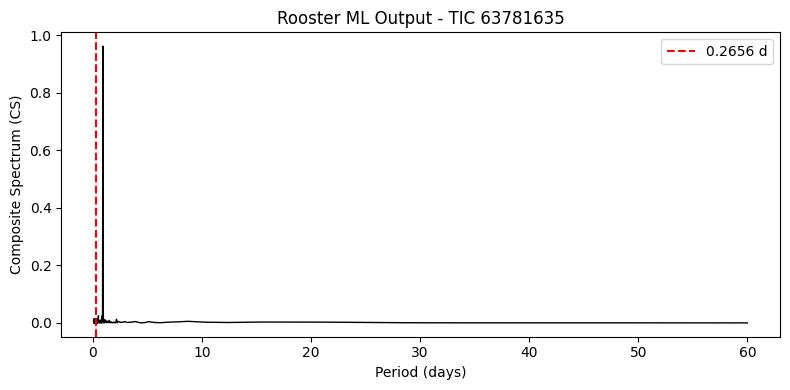

In [11]:
import os
import numpy as np
import pandas as pd
import lightkurve as lk
import star_privateer as sp
import matplotlib.pyplot as plt

# ===============================
# 1. Setup
# ===============================
# Make output folder
if not os.path.exists("stellar_analysis_features"):
    os.mkdir("stellar_analysis_features")

# Example TIC target
target = "TIC 63781635"

# ===============================
# 2. Download TESS light curve
# ===============================
search = lk.search_lightcurve(target, mission="TESS")
lc = search.download()
lc = lc.remove_nans().normalize()

# Convert to numpy arrays
t = np.asarray(lc.time.value)
s = np.asarray(lc.flux.value)

# ===============================
# 3. Run Rooster analysis pipeline
# ===============================
(_, _,  # skip p_ps and p_acf
 ps, acf,
 cs, features,
 feature_names,
 fig) = sp.analysis_pipeline(
    t, s,
    pmin=0.1, pmax=60,        # search range in days
    figsize=(8,10),
    wavelet_analysis=False,
    plot=False,                # turn off default plot
    filename=None
)

# ===============================
# 4. Extract CS best period + uncertainty
# ===============================
period_grid = np.linspace(0.1, 60, len(cs))  # actual x-axis in days

prot_cs, err_cs, _ = sp.compute_prot_err_gaussian_fit(
    period_grid, cs,
    n_profile=3,
    threshold=0.5,
    pmin=0.2, pmax=0.3     # narrowed around LS result
)

# Save results to CSV
fileout = f"stellar_analysis_features/{target.replace(' ', '_')}_rotation.csv"
df = pd.DataFrame([{
    "TIC_ID": target,
    "Rotation_Period_CS_d": prot_cs,
    "Error_CS_d": err_cs
}])
df.to_csv(fileout, index=False)

print(f" Recommended rotation period (CS): {prot_cs:.4f} ± {err_cs:.4f} d")
print(f"Results saved to {fileout}")

# ===============================
# 5. Custom Rooster Plot (fixed x-axis in days)
# ===============================
plt.figure(figsize=(8,4))
plt.plot(period_grid, cs, color="black", lw=1)
plt.axvline(prot_cs, color="red", ls="--", label=f"{prot_cs:.4f} d")
plt.xlabel("Period (days)")
plt.ylabel("Composite Spectrum (CS)")
plt.title(f"Rooster ML Output - {target}")
plt.legend()
plt.tight_layout()
plt.savefig("ROOSTER_63781635.png", dpi=300)
plt.show()
